Author: Pascal, pascal@bayesimpact.org

Date: 2019-10-23

# ROME update from v339 to v341

In October 2019 a new version of the ROME was released. I want to investigate what changed and whether we need to do anything about it.

You might not be able to reproduce this notebook, mostly because it requires to have the two versions of the ROME in your `data/rome/csv` folder which happens only just before we switch to v341. You will have to trust me on the results ;-)

Skip the run test because it requires older versions of the ROME.

In [1]:
import collections
import glob
import os
from os import path

import matplotlib_venn
import pandas as pd

rome_path = path.join(os.getenv('DATA_FOLDER'), 'rome/csv')

OLD_VERSION = '339'
NEW_VERSION = '341'

old_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(OLD_VERSION)))
new_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(NEW_VERSION)))

First let's check if there are new or deleted files (only matching by file names).

In [2]:
new_files = new_version_files - frozenset(f.replace(OLD_VERSION, NEW_VERSION) for f in old_version_files)
deleted_files = old_version_files - frozenset(f.replace(NEW_VERSION, OLD_VERSION) for f in new_version_files)

print('{:d} new files'.format(len(new_files)))
print('{:d} deleted files'.format(len(deleted_files)))

0 new files
1 deleted files


Let's find this deleted file:

In [3]:
list(deleted_files)

['/home/jovyan/data/rome/csv/unix_en_tete_regroupement_v339_utf8.csv']

OK, not too bad: this is a file we've never used. We'll still check its content to make sure:


In [4]:
en_tete_regroupement = pd.read_csv(list(deleted_files)[0])

display(en_tete_regroupement.head())
print(f'{len(en_tete_regroupement)} rows')

,code_tete_rgpmt,libelle_en_tete_regroupement
0,0,Accueillir des passagers lors de :
1,1,Actionner et manoeuvrer des équipements :
2,2,Adapter ou fabriquer des accessoires de costum...
3,3,Adapter un écrit :
4,4,Administrer un système :


606 rows


It looks like a header for some kinds of activities. Not that big a deal.

Now let's set up a dataset that, for each table, links both the old and the new file together.

In [5]:
# Load all ROME datasets for the two versions we compare.
VersionedDataset = collections.namedtuple('VersionedDataset', ['basename', 'old', 'new'])
def read_csv(filename):
    try:
        return pd.read_csv(filename)
    except pd.errors.ParserError:
        display(f'While parsing: {filename}')
        raise

rome_data = [VersionedDataset(
        basename=path.basename(f),
        old=read_csv(f.replace(NEW_VERSION, OLD_VERSION)),
        new=read_csv(f))
    for f in sorted(new_version_files)]

def find_rome_dataset_by_name(data, partial_name):
    for dataset in data:
        if 'unix_{}_v{}_utf8.csv'.format(partial_name, NEW_VERSION) == dataset.basename:
            return dataset
    raise ValueError('No dataset named {}, the list is\n{}'.format(partial_name, [d.basename for d in data]))

Let's make sure the structure hasn't changed:

In [6]:
for dataset in rome_data:
    if set(dataset.old.columns) != set(dataset.new.columns):
        print('Columns of {} have changed.'.format(dataset.basename))

Columns of unix_referentiel_appellation_v341_utf8.csv have changed.


OK, let's check what's new in there:

In [7]:
jobs = find_rome_dataset_by_name(rome_data, 'referentiel_appellation')
print(f'New columns: {set(jobs.old.columns) - set(jobs.new.columns)}')
print(f'Old columns: {set(jobs.new.columns) - set(jobs.old.columns)}')

New columns: {'libelle_type_section_appellation'}
Old columns: {'lib_type_section_appellation'}


Ouch, it seems they have decided to rename one column. Lucky us we never used it.

Now let's see for each file if there are more or less rows.

In [8]:
same_row_count_files = 0
for dataset in rome_data:
    diff = len(dataset.new.index) - len(dataset.old.index)
    if diff > 0:
        print('{:d}/{:d} values added in {}'.format(
            diff, len(dataset.new.index), dataset.basename))
    elif diff < 0:
        print('{:d}/{:d} values removed in {}'.format(
            -diff, len(dataset.old.index), dataset.basename))
    else:
        same_row_count_files += 1
print('{:d}/{:d} files with the same number of rows'.format(
    same_row_count_files, len(rome_data)))

130/31423 values added in unix_coherence_item_v341_utf8.csv
1/11718 values added in unix_cr_gd_dp_appellations_v341_utf8.csv
859/2043 values removed in unix_item_arborescence_v341_utf8.csv
36/13569 values added in unix_item_v341_utf8.csv
131/43017 values added in unix_liens_rome_referentiels_v341_utf8.csv
1509/8971 values added in unix_referentiel_activite_riasec_v341_utf8.csv
1/11062 values added in unix_referentiel_appellation_v341_utf8.csv
13/20 files with the same number of rows


There are some minor changes in many files, but based on my knowledge of ROME, none from the main files.

The most interesting ones are in referentiel_appellation, item, and liens_rome_referentiels, so let's see more precisely.

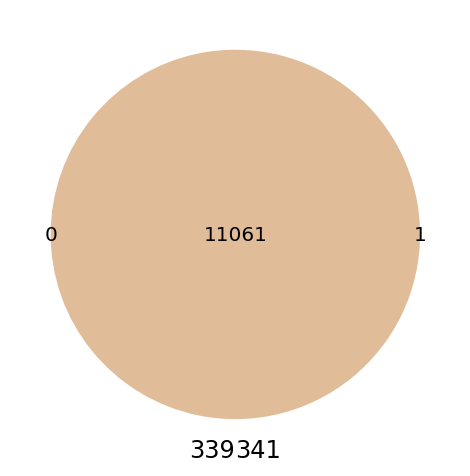

In [9]:
jobs = find_rome_dataset_by_name(rome_data, 'referentiel_appellation')

new_jobs = set(jobs.new.code_ogr) - set(jobs.old.code_ogr)
obsolete_jobs = set(jobs.old.code_ogr) - set(jobs.new.code_ogr)
stable_jobs = set(jobs.new.code_ogr) & set(jobs.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_jobs), len(new_jobs), len(stable_jobs)), (OLD_VERSION, NEW_VERSION));

Alright, so the only change seems to be 1 new job added. Let's take a look (only showing interesting fields):

In [10]:
pd.options.display.max_colwidth = 2000
jobs.new[jobs.new.code_ogr.isin(new_jobs)][['code_ogr', 'libelle_appellation_long', 'code_rome']]

,code_ogr,libelle_appellation_long,code_rome
11061,200000,Coordinateur / Coordinatrice BIM,F1106


That's indeed a new job related to digitalization of the construction industry.

OK, let's check at the changes in items:

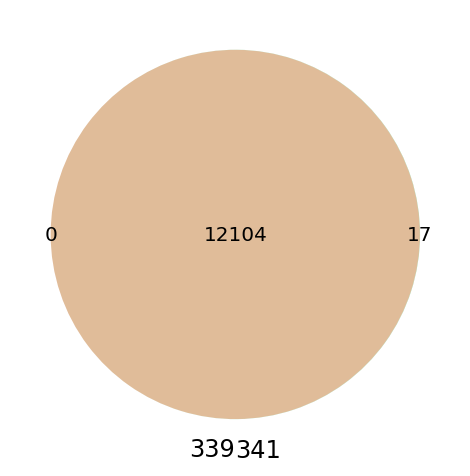

In [11]:
items = find_rome_dataset_by_name(rome_data, 'item')

new_items = set(items.new.code_ogr) - set(items.old.code_ogr)
obsolete_items = set(items.old.code_ogr) - set(items.new.code_ogr)
stable_items = set(items.new.code_ogr) & set(items.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_items), len(new_items), len(stable_items)), (OLD_VERSION, NEW_VERSION));

As anticipated it is a very minor change (hard to see it visually): there are 17 new ones have been created. Let's have a look at them.

In [12]:
items.new[items.new.code_ogr.isin(new_items)].head()

,code_ogr,libelle,code_type_referentiel,code_ref_rubrique,code_tete_rgpmt,libelle_activite_impression,libelle_en_tete_regroupement
5954,115833,Utilisation d'applications clientes réseau,1,7,NaN,NaN,NaN
6220,116809,Connaissance des bases des DTU (Document Technique Unifié),1,7,NaN,NaN,NaN
6294,117113,Organiser et planifier la visite de biens immobiliers,2,6,NaN,NaN,NaN
6558,117755,Dispositif TRACFIN (Traitement du renseignement et action contre les circuits financiers clandestins),1,7,NaN,NaN,NaN
6559,117755,Dispositif TRACFIN (Traitement du renseignement et action contre les circuits financiers clandestins),1,10,NaN,NaN,NaN


The new ones seem legit to me.

The changes in `liens_rome_referentiels` include changes for those items, so let's only check the changes not related to those.

In [13]:
links = find_rome_dataset_by_name(rome_data, 'liens_rome_referentiels')
old_links_on_stable_items = links.old[links.old.code_ogr.isin(stable_items)]
new_links_on_stable_items = links.new[links.new.code_ogr.isin(stable_items)]

old = old_links_on_stable_items[['code_rome', 'code_ogr']]
new = new_links_on_stable_items[['code_rome', 'code_ogr']]

links_merged = old.merge(new, how='outer', indicator=True)
links_merged['_diff'] = links_merged._merge.map({'left_only': 'removed', 'right_only': 'added'})
links_merged._diff.value_counts()

added    94
Name: _diff, dtype: int64

So in addition to the added items, there are few fixes. Let's have a look at them:

In [14]:
job_group_names = find_rome_dataset_by_name(rome_data, 'referentiel_code_rome').new.set_index('code_rome').libelle_rome
item_names = items.new.set_index('code_ogr').libelle.drop_duplicates()
links_merged['job_group_name'] = links_merged.code_rome.map(job_group_names)
links_merged['item_name'] = links_merged.code_ogr.map(item_names)
display(links_merged[links_merged._diff == 'removed'].dropna().head(5))
links_merged[links_merged._diff == 'added'].dropna().head(5)


,code_rome,code_ogr,_merge,_diff,job_group_name,item_name


,code_rome,code_ogr,_merge,_diff,job_group_name,item_name
31293,B1604,119242,right_only,added,Réparation - montage en systèmes horlogers,Organiser un poste de travail
31294,B1604,106189,right_only,added,Réparation - montage en systèmes horlogers,Utilisation d'appareil optique
31295,B1604,118331,right_only,added,Réparation - montage en systèmes horlogers,Utilisation d'outillages manuels
31296,B1604,120299,right_only,added,Réparation - montage en systèmes horlogers,Veille informationnelle
31297,B1604,117476,right_only,added,Réparation - montage en systèmes horlogers,Trier et évacuer des déchets


Those fixes make sense (not sure why they were not done before, but let's not complain: it is fixed now).

That's all the changes we wanted to check (no change in `referentiel_code_rome`).

# Conclusion

The new version of ROME, v341, introduces very minor changes which reflect quite well what they wrote in their [changelog](http://www.pole-emploi.org/files/live/sites/peorg/files/documents/Statistiques-et-analyses/Open-data/ROME/ROME_AppropriationThematique.pdf).

Technically they were some format changes (some of them were discovered while preparing this notebook):
* The CSV files are now zipped under a `csv` folder.
* The double quotes that are not escaped (they weren't before either) are now problematic because they contain text with spaces and commas which throws off the CSV parser.
* The file `en_tete_regroupement` containing phrasing headers that we've never used has been removed

The transition should be transparent with a very small advantage over the old version.